In [ ]:
import pandas as pd
import numpy as np
import math
import json
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from PIL import Image
from tqdm import tqdm

In [4]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [6]:
train_df = pd.read_csv('/kaggle/working/ddr-equal/aug.csv')
print(train_df.shape)
train_df.head()

(6594, 2)


,id_code,diagnosis
0,0__0_8989.jpg,0
1,0__0_2738.jpg,0
2,0__0_7643.jpg,0
3,0__0_7122.jpg,0
4,0__0_1522.jpg,0


diagnosis
2    1329
3    1321
1    1318
4    1318
0    1308
Name: count, dtype: int64

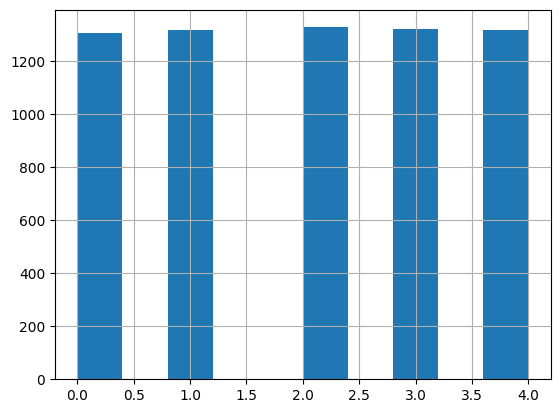

In [7]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [8]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [9]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'/kaggle/working/ddr-equal/aug_images/{image_id}')

100%|██████████| 6594/6594 [02:16<00:00, 48.35it/s]


In [10]:
y_train = pd.get_dummies(train_df['diagnosis']).values
print(x_train.shape)
print("One-hot encoded y_train:", y_train.sum(axis=0))

(6594, 224, 224, 3)
One-hot encoded y_train: [1308 1318 1329 1321 1318]


In [11]:
x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_train,  
    y_train,
    test_size=0.1,
    random_state=2019
)

x_train_partial, x_val, y_train_partial, y_val = train_test_split(
    x_train_full, y_train_full, 
    test_size=0.1, 
    random_state=2019
)

x_train.shape

(6594, 224, 224, 3)

In [12]:
y_train.shape

(6594, 5)

In [13]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15, 
        fill_mode='constant',
        cval=0.,  
        horizontal_flip=True,  
        vertical_flip=True,  
    )

data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [14]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

df = pd.read_csv(r'D:/kaggle/working/ddr-equal/aug.csv') 

In [15]:
df.head()

,id_code,diagnosis
0,0__0_8989.jpg,0
1,0__0_2738.jpg,0
2,0__0_7643.jpg,0
3,0__0_7122.jpg,0
4,0__0_1522.jpg,0


In [16]:
def rename_to_path(image_name):
    return f'D:/kaggle/working/ddr-equal/aug_images/{image_name}'

df['id_code'] = df['id_code'].apply(rename_to_path)
df['diagnosis'].value_counts()

diagnosis
2    1329
3    1321
1    1318
4    1318
0    1308
Name: count, dtype: int64

In [17]:
input_tensor = tfl.Input(shape=(224, 224, 3))
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
x=base_model.output
x = tfl.GlobalAveragePooling2D()(x)
x = tfl.Dropout(0.5)(x) 
x = tfl.Dense(5, activation = 'softmax')(x)

In [19]:
model = tf.keras.Model(inputs = input_tensor, outputs = x)

In [20]:
checkpoint = ModelCheckpoint(
    filepath='D:\Final Year Project\inception_model.keras',
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',             
    verbose=1,               
)

model.compile(
            # optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
            loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [21]:
history = model.fit(data_generator, validation_data=(x_val,y_val), epochs=10, callbacks=[checkpoint])

z:\ml\ml\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4464 - loss: 1.3146
Epoch 1: val_accuracy improved from -inf to 0.73064, saving model to D:\Final Year Project\inception_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.4471 - loss: 1.3132 - val_accuracy: 0.7306 - val_loss: 0.6612
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7879 - loss: 0.5865
Epoch 2: val_accuracy improved from 0.73064 to 0.87879, saving model to D:\Final Year Project\inception_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.7881 - loss: 0.5862 - val_accuracy: 0.8788 - val_loss: 0.3043
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8967 - loss: 0.2873
Epoch 3: val_accuracy improved from 0.87879 to 0.95118, saving model to D:\Final Year Project\inception_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.8967 - loss: 0.2872 - val_accuracy: 0.9512 - val_loss: 0.1437
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/

In [22]:
y_pred = np.argmax(model.predict(x_test), axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 589ms/step


In [23]:
y_true = np.argmax(y_test, axis=1)  

In [24]:
print(y_pred.shape)
print(y_true.shape)

(660,)
(660,)


Training history saved to 'history.json'.
Loaded history: {'accuracy': [0.5805277228355408, 0.8121019005775452, 0.9052168726921082, 0.9366090297698975, 0.963148295879364, 0.9714892506599426, 0.9767971038818359, 0.9798301458358765, 0.9840764403343201, 0.9816499948501587], 'loss': [1.0285999774932861, 0.5218976140022278, 0.2612502872943878, 0.18405726552009583, 0.11060301214456558, 0.08599616587162018, 0.07305070757865906, 0.05856125056743622, 0.04876239597797394, 0.053228698670864105], 'val_accuracy': [0.7306397557258606, 0.8787878751754761, 0.9511784315109253, 0.9579124450683594, 0.9797979593276978, 0.9848484992980957, 0.9478114247322083, 0.9983165264129639, 0.9898989796638489, 0.9949495196342468], 'val_loss': [0.6611650586128235, 0.30427077412605286, 0.14370524883270264, 0.13742956519126892, 0.0698775127530098, 0.042724501341581345, 0.16486385464668274, 0.013424050062894821, 0.018932556733489037, 0.024323688820004463]}


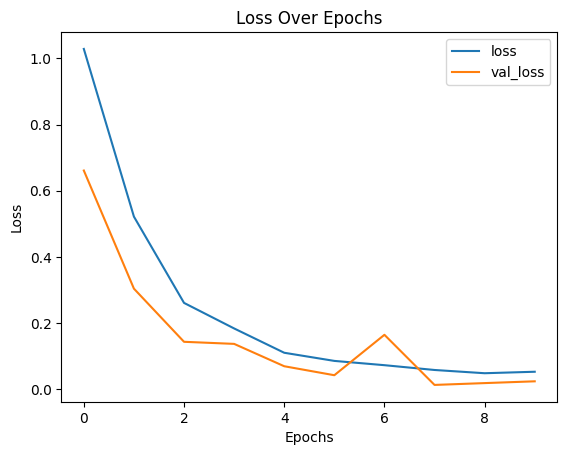

In [25]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)
print("Training history saved to 'history.json'.")


with open('history.json', 'r') as f:
    loaded_history = json.load(f)
print("Loaded history:", loaded_history)


history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

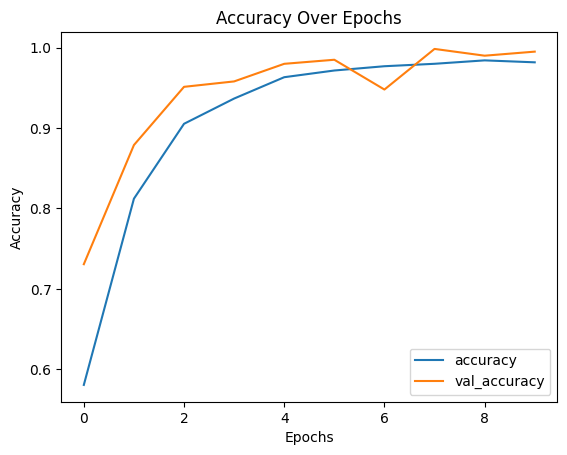

In [ ]:
history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [27]:
conf_matrix = confusion_matrix(y_true, y_pred) 
print('Confusion matrix:')
print(conf_matrix)

Confusion matrix:
[[120   0   0   0   0]
 [  1 132   0   0   0]
 [  0   0 143   0   0]
 [  1   1   2 114   3]
 [  0   0   0   0 143]]


In [28]:
from mlxtend.plotting import plot_confusion_matrix

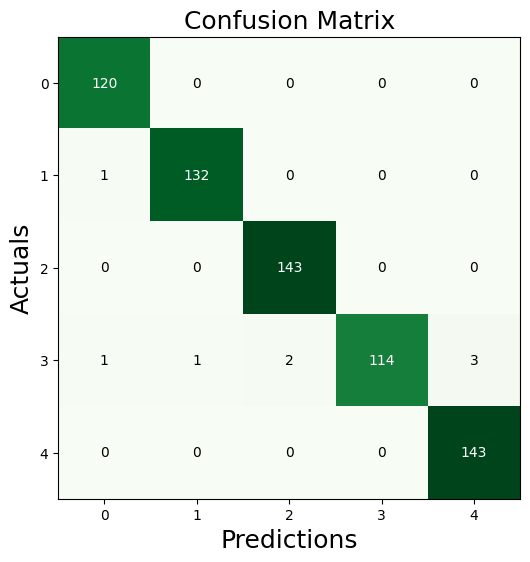

In [29]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [30]:
class_names = [str(i) for i in range(5)]
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       120
           1       0.99      0.99      0.99       133
           2       0.99      1.00      0.99       143
           3       1.00      0.94      0.97       121
           4       0.98      1.00      0.99       143

    accuracy                           0.99       660
   macro avg       0.99      0.99      0.99       660
weighted avg       0.99      0.99      0.99       660

